In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('./mpc')
sys.path.append('./training')
sys.path.append('./mpc/bll')
sys.path.append('./mpc/cqr')
sys.path.append('./mpc/nn')
sys.path.append('./model')
import config
import train_standard_NN
import train_BLL
import train_CQR

import mpc_nn_class
import data_based_do_mpc_model_nn
import save_nn_results

import mpc_bll_class
import data_based_do_mpc_model_bll
import save_bll_results

import mpc_cqr_class
import data_based_do_mpc_model_cqr
import save_cqr_results

from prepare_model import prepare_model
import config_mpc

C:\Users\smcojohn\AppData\Local\miniconda3\envs\stochastic_sfc\Lib\site-packages\do_mpc\sysid\__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
C:\Users\smcojohn\AppData\Local\miniconda3\envs\stochastic_sfc\Lib\site-packages\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


Running pre simulation


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:39<00:00, 12.55it/s]


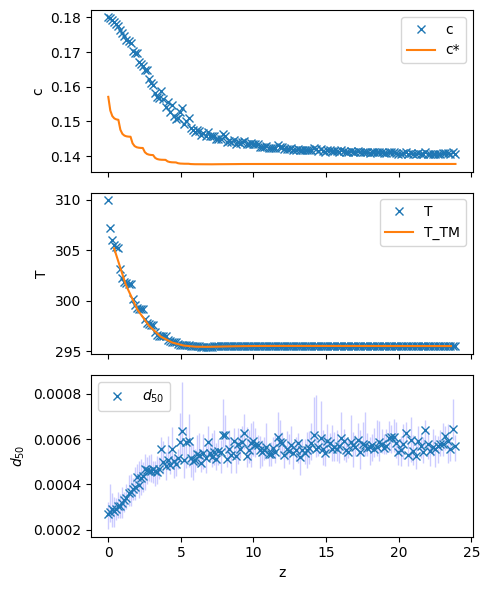

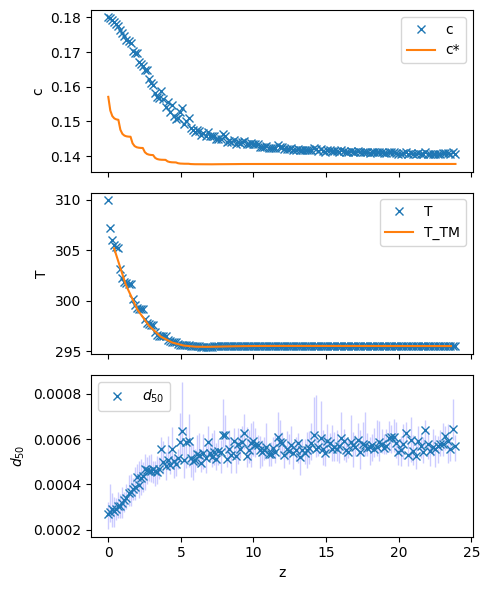

In [2]:
# prepare first-principle model as simulator
sfc_model = prepare_model()
sfc_model.plot_states_over_length()

In [3]:
# initial states and inputs
x0 = np.array([config_mpc.T_PM_0, config_mpc.T_TM_0, config_mpc.c_0, config_mpc.d10_0, config_mpc.d50_0, config_mpc.d90_0])
u0 = np.array([config_mpc.mf_PM_0, config_mpc.mf_TM_0, config_mpc.Q_g_0, config_mpc.w_crystal_0])

In [4]:
# run mpc using standard NN as internal model

# load trained NN model and data
nn_model = pickle.load(open('./data based models/NN_model.pkl', 'rb'))
nn_data = nn_model.data

# mpc_NN class
mpc_nn = mpc_nn_class.MPC_NN(sfc_model, nn_data, nn_model)
mpc_nn.setup_mpc(config_mpc.n_horizon, config_mpc.dt_controller, config.bounds, nn_data.l)

# initial narx vector
x_next = mpc_nn_class.initialize_narx(x0, u0, nn_data)

# steps needed for first-principle model for one controller step
steps_internal = int(config_mpc.dt_databased/config_mpc.dt_sfc_model)

In [5]:
# run mpc
for t_i in range(config_mpc.t_steps):
    print(f'Calculating step {t_i+1} of {config_mpc.t_steps}.')
    # make mpc step
    u_mpc = mpc_nn.controller.make_step(x_next)

    # extrac inputs for first-principle model
    sfc_model_inputs = mpc_nn_class.model_input(nn_data.keys_inputs, u_mpc, config.default_inputs, w_crystal=mpc_nn.controller.data['_tvp','w_crystal'][-1].squeeze())

    # simulate first-principle model
    for _ in range(steps_internal):
        sfc_model.make_step(*sfc_model_inputs)

    # extract data-based states from first-principle model
    x_next = mpc_nn_class.mpc_input(sfc_model, nn_data, x_next, w_crystal=mpc_nn.controller.data['_tvp','w_crystal'][-1].squeeze())

Calculating step 1 of 150.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     6016
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:    15657

Reallocating memory for MA57: lfact (93692)
Reallocating memory for MA57: lfact (98653)
Total number of variables............................:      836
                     variables with only lower bounds:       20
                variables with lower and upper bounds:       60
                     variables with only upper b

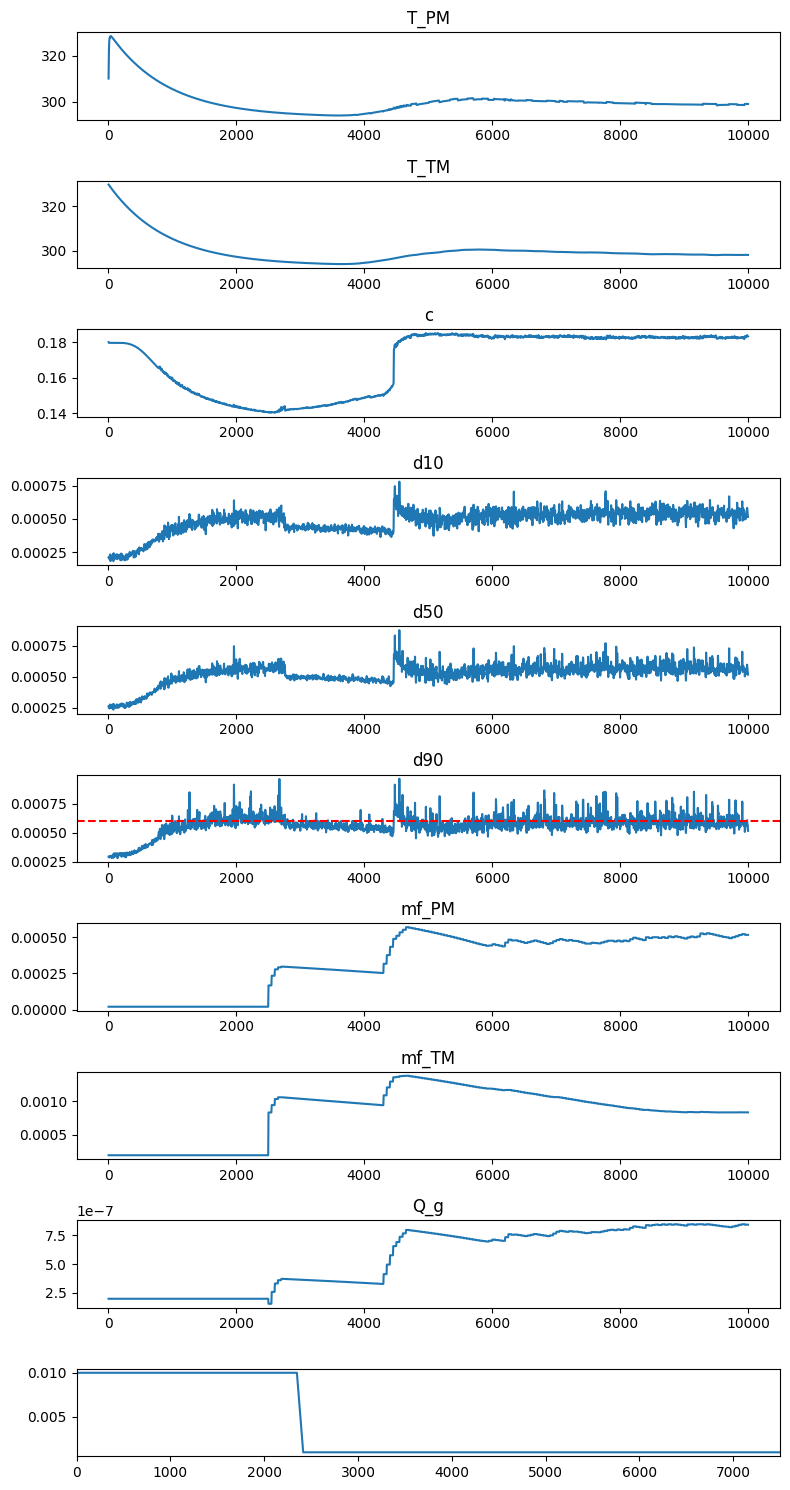

In [6]:
# visualize results

# plot states and inputs
fig, ax = plt.subplots(10, 1, figsize=(8, 15))

for i, key in enumerate(nn_data.keys_states):
    ax[i].plot(sfc_model.output['time'],sfc_model.output[key], label='Simulator')
    ax[i].set_title(key)
    if key == 'd90':  # add horizontal line at 4e-4
        set_size = mpc_nn.controller.data['_tvp', 'max_d90'][0]
        ax[i].axhline(y=set_size, color='r', linestyle='--')

for i, key in enumerate(nn_data.keys_inputs):
    ax[i+len(nn_data.keys_states)].plot(sfc_model.output['time'],sfc_model.output[key])
    ax[i+len(nn_data.keys_states)].set_title(key)


ax[-1].plot(np.linspace(0,config_mpc.steps_pre_simulation*5+config_mpc.t_steps*50,config_mpc.t_steps),mpc_nn.controller.data['_tvp','w_crystal'])
ax[-1].set_xlim([0, config_mpc.t_steps*50])

fig.tight_layout()

Running pre simulation


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


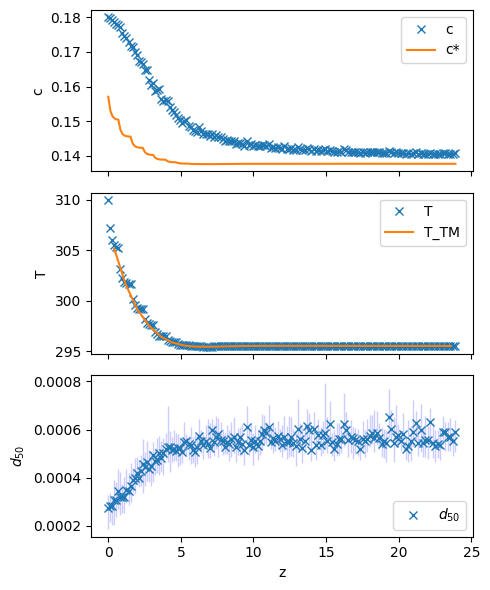

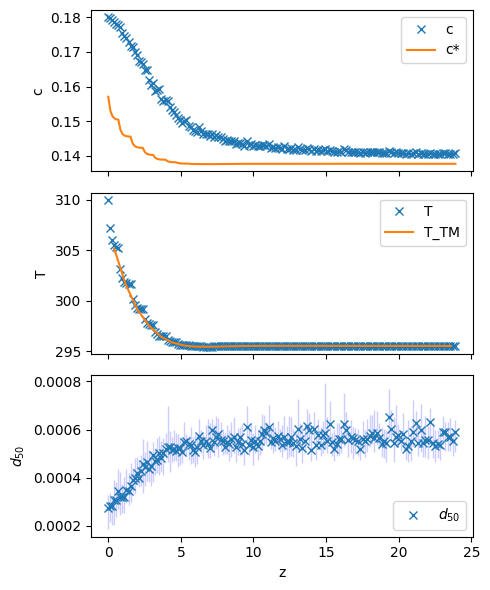

In [7]:
# prepare first-principle model as simulator
sfc_model = prepare_model()
sfc_model.plot_states_over_length()

In [8]:
# run mpc using cqr model as internal model

# load trained cqr model and data
cqr_model = pickle.load(open('./data based models/cqr_model.pkl', 'rb'))
cqr_data = cqr_model.data

# mpc_cqr class
mpc_cqr = mpc_cqr_class.MPC_CQR(sfc_model, cqr_data, cqr_model)
mpc_cqr.setup_mpc(config_mpc.n_horizon, config_mpc.dt_controller, config.bounds, cqr_data.l)

# initial narx vector
x_next = mpc_cqr_class.initialize_narx(x0, u0, cqr_data)

# steps needed for first-principle model for one controller step
steps_internal = int(config_mpc.dt_databased/config_mpc.dt_sfc_model)

In [9]:
# run mpc
for t_i in range(config_mpc.t_steps):
    print(f'Calculating step {t_i+1} of {config_mpc.t_steps}.')
    # make mpc step
    u_mpc = mpc_cqr.controller.make_step(x_next)

    # extrac inputs for first-principle model
    sfc_model_inputs = mpc_cqr_class.model_input(cqr_data.keys_inputs, u_mpc, config.default_inputs, w_crystal=mpc_cqr.controller.data['_tvp','w_crystal'][-1].squeeze())

    # simulate first-principle model
    for _ in range(steps_internal):
        sfc_model.make_step(*sfc_model_inputs)

    # extract data-based states from first-principle model
    x_next = mpc_cqr_class.mpc_input(sfc_model, cqr_data, x_next, w_crystal=mpc_cqr.controller.data['_tvp','w_crystal'][-1].squeeze())

Calculating step 1 of 150.
This is Ipopt version 3.14.11, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    17976
Number of nonzeros in inequality constraint Jacobian.:      120
Number of nonzeros in Lagrangian Hessian.............:    45411

Reallocating memory for MA57: lfact (270683)
Total number of variables............................:     2508
                     variables with only lower bounds:       60
                variables with lower and upper bounds:      180
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2196
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.0224

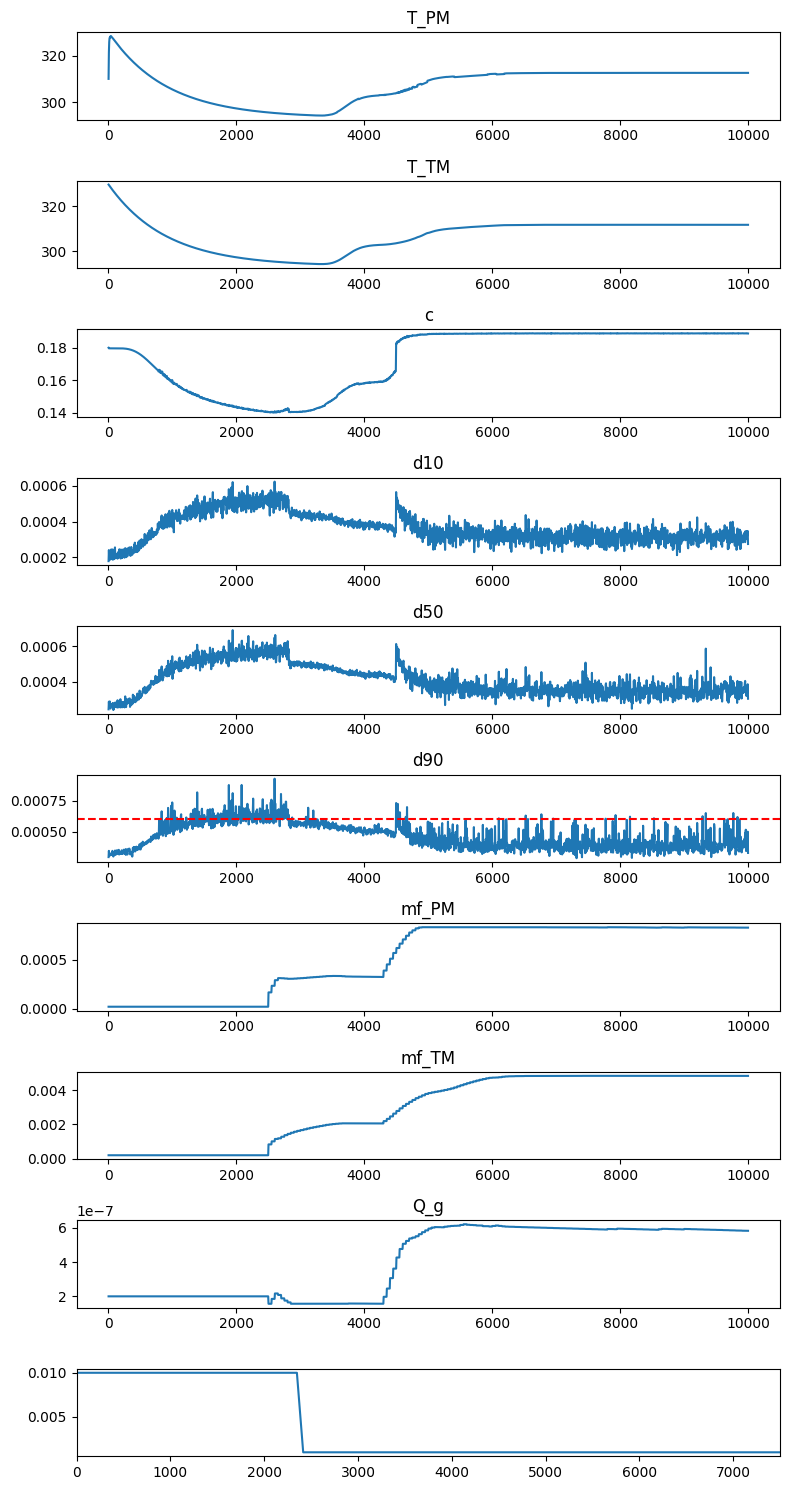

In [10]:
# visualize results

# plot states and inputs
fig, ax = plt.subplots(10, 1, figsize=(8, 15))

for i, key in enumerate(cqr_data.keys_states):
    ax[i].plot(sfc_model.output['time'],sfc_model.output[key], label='Simulator')
    ax[i].set_title(key)
    if key == 'd90':  # add horizontal line at 4e-4
        set_size = mpc_cqr.controller.data['_tvp', 'max_d90'][0]
        ax[i].axhline(y=set_size, color='r', linestyle='--')

for i, key in enumerate(cqr_data.keys_inputs):
    ax[i+len(cqr_data.keys_states)].plot(sfc_model.output['time'],sfc_model.output[key])
    ax[i+len(cqr_data.keys_states)].set_title(key)


ax[-1].plot(np.linspace(0,config_mpc.steps_pre_simulation*5+config_mpc.t_steps*50,config_mpc.t_steps),mpc_cqr.controller.data['_tvp','w_crystal'])
ax[-1].set_xlim([0, config_mpc.t_steps*50])

fig.tight_layout()

Running pre simulation


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:40<00:00, 12.48it/s]


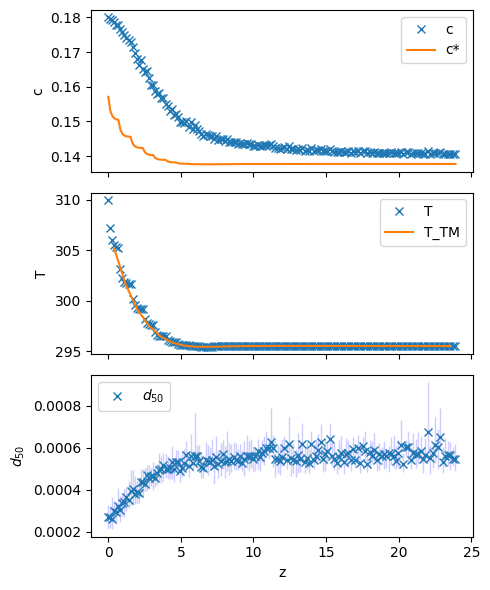

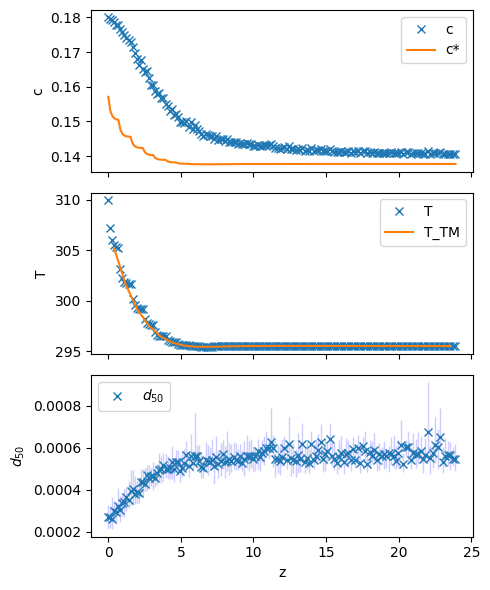

In [11]:
# prepare first-principle model as simulator
sfc_model = prepare_model()
sfc_model.plot_states_over_length()

In [13]:
# run mpc using bll model as internal model

# load trained bll model and data
bll_model = pickle.load(open('./data based models/bll_model.pkl', 'rb'))
bll_data = bll_model.data

# mpc_cqr class
mpc_bll = mpc_bll_class.MPC_BLL(sfc_model, bll_data, bll_model)
mpc_bll.setup_mpc(config_mpc.n_horizon, config_mpc.dt_controller, config.bounds, bll_data.l)

# initial narx vector
x_next = mpc_bll_class.initialize_narx(x0, u0, bll_data)

# steps needed for first-principle model for one controller step
steps_internal = int(config_mpc.dt_databased/config_mpc.dt_sfc_model)

C:\Users\smcojohn\AppData\Local\miniconda3\envs\stochastic_sfc\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
# run mpc
for t_i in range(config_mpc.t_steps):
    print(f'Calculating step {t_i+1} of {config_mpc.t_steps}.')
    # make mpc step
    u_mpc = mpc_bll.controller.make_step(x_next)

    # extrac inputs for first-principle model
    sfc_model_inputs = mpc_bll_class.model_input(bll_data.keys_inputs, u_mpc, config.default_inputs, w_crystal=mpc_bll.controller.data['_tvp','w_crystal'][-1].squeeze())

    # simulate first-principle model
    for _ in range(steps_internal):
        sfc_model.make_step(*sfc_model_inputs)

    # extract data-based states from first-principle model
    x_next = mpc_bll_class.mpc_input(sfc_model, bll_data, x_next, w_crystal=mpc_bll.controller.data['_tvp','w_crystal'][-1].squeeze())

Calculating step 1 of 150.
This is Ipopt version 3.14.11, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    17976
Number of nonzeros in inequality constraint Jacobian.:      120
Number of nonzeros in Lagrangian Hessian.............:    45411

Reallocating memory for MA57: lfact (266149)
Total number of variables............................:     2508
                     variables with only lower bounds:       60
                variables with lower and upper bounds:      180
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2196
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.0224

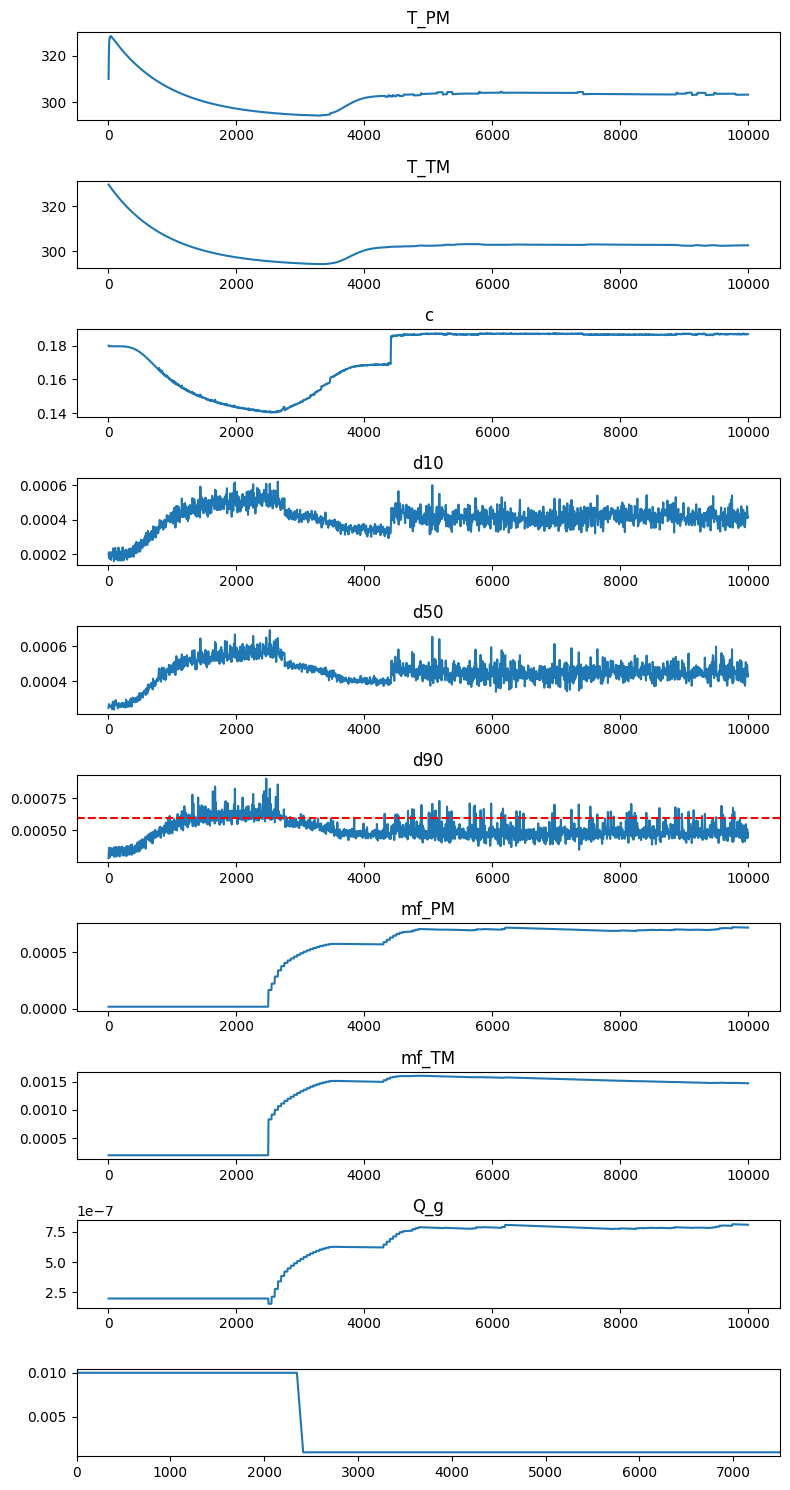

In [15]:
# visualize results

# plot states and inputs
fig, ax = plt.subplots(10, 1, figsize=(8, 15))

for i, key in enumerate(bll_data.keys_states):
    ax[i].plot(sfc_model.output['time'],sfc_model.output[key], label='Simulator')
    ax[i].set_title(key)
    if key == 'd90':  # add horizontal line at 4e-4
        set_size = mpc_bll.controller.data['_tvp', 'max_d90'][0]
        ax[i].axhline(y=set_size, color='r', linestyle='--')

for i, key in enumerate(bll_data.keys_inputs):
    ax[i+len(bll_data.keys_states)].plot(sfc_model.output['time'],sfc_model.output[key])
    ax[i+len(bll_data.keys_states)].set_title(key)


ax[-1].plot(np.linspace(0,config_mpc.steps_pre_simulation*5+config_mpc.t_steps*50,config_mpc.t_steps),mpc_bll.controller.data['_tvp','w_crystal'])
ax[-1].set_xlim([0, config_mpc.t_steps*50])

fig.tight_layout()